# Introduction

Below is our exploratory data analysis of the ChaLearn Looking at People dataset of 7.6k photos of human faces. It also contains functions and GPU platform script code for training a model to identify the age of these faces using a ResNet50 architecture. We will include some conclusions about the analysis and training to prepare us for the ultimate task of reading faces at the supermarket checkout and determining their age.

## Initialization

In [29]:
# Data Science libraries
import pandas as pd

# Deep Learning libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img

# Plotting and graphics libraries
import matplotlib.pyplot as plt

In [30]:
# File management
filepath = '/datasets/'
photopath = filepath + 'final_files/'
labelpath = filepath + 'labels.csv'

## Load Data

We placed our data from ChaLearn in a local `./datasets/` folder that is not included in this GitHub repository. We did include the csv with label data. Our final /datasets/ folder contained:
- The `final_files` folder with 7.6k photos inside
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`

Given the fact that the number of image files is rather high, we will build a generator with the ImageDataGenerator generator and process only a sub-section of images at a time.

In [31]:
# Init generator and dataframe
datagen = ImageDataGenerator(
    rescale=1./255
)
target_labels = pd.read_csv(labelpath)

In [32]:
# Init flow object from dataframe, not from directory, to map images to the age data contained in 'target_labels'
datagen_flow = datagen.flow_from_dataframe(
    dataframe=target_labels,
    directory=photopath,
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=16,
    class_mode='raw',
    seed=12345
)
features, target = next(datagen_flow)

Found 7591 validated image filenames.


## EDA

We will verify that the directory image generator load above matches the size of our dataframe containing all file names and corresponding target age data:

In [33]:
# Return number of images
print("Number of images:", target_labels.shape[0])

Number of images: 7591


Then we can conduct a brief overview of the age distribution:

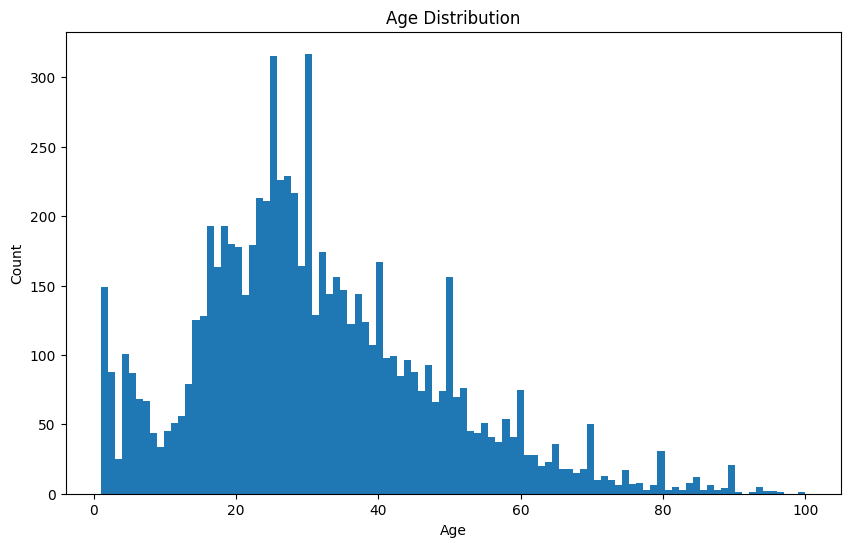

In [34]:
# Display histogram
plt.figure(figsize=(10, 6))
plt.hist(target_labels['real_age'], bins=100)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

It looks like we have a right-skewed distribution, with peaks in the 25-30 age range. For our task in the checkout line, we are unlikely to be scanning babies' or toddlers' faces, but nonetheless training on the entire age range creates an effective model.

We also want to check out some example images across the entire age spectrum. If we conduct a random sample, we aren't guaranteed to see images from each age group. So we will create 15 target ages, filter the dataframe by target age, group by age, and then sample the GroupBy() object. In this task, we care about the legal drinking age threshold, which varies by country but tends to be in the 16-21 range. We'll weight this age range higher in our example images to better understand those ages' images.

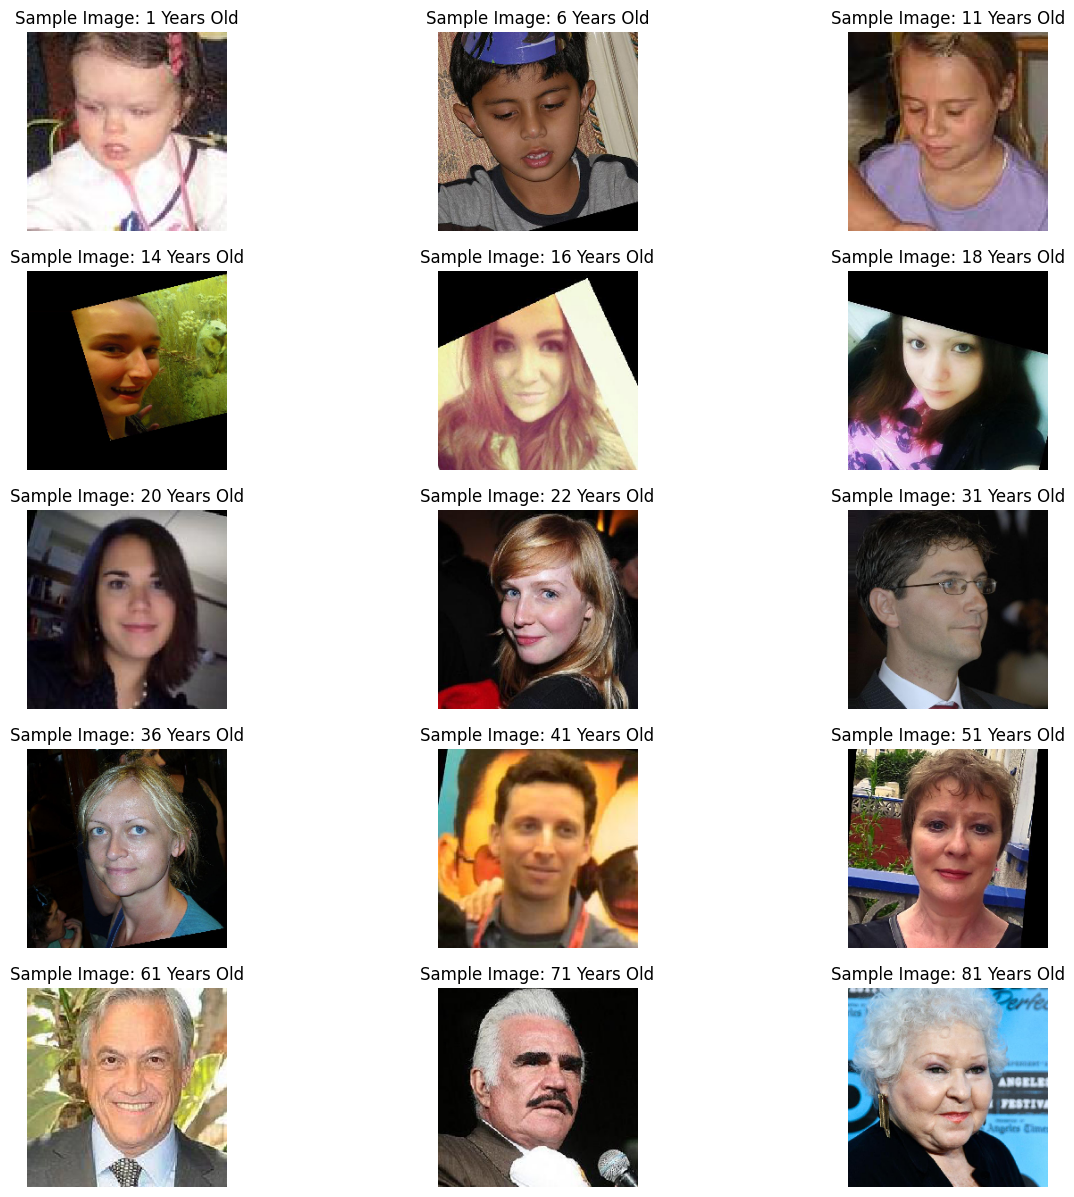

In [35]:
# Get filtered dataframe of one sample per target age
target_ages = [1, 6, 11, 14, 16, 18, 20, 22, 31, 36, 41, 51, 61, 71, 81]
filter_df = target_labels.query('real_age in @target_ages').groupby('real_age').sample(
    n=1, 
    random_state=12345
)

# Display
plt.figure(figsize=(15, 15))
for i, (index, filter_row) in enumerate(filter_df.iterrows()):
    age = filter_row['real_age']
    img = load_img(photopath + filter_row['file_name'], target_size=(224, 224))
    
    plt.subplot(5, 3, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Sample Image: {age} Years Old')

plt.show()

These images have been rotated and resized to orient the face in approximately the same position across all images. This consistency boosts the model's performance but of course necessitates that all data passed is in similar ranges.

I would predict that models could have a difficult time with the drinking age range of 16-21. Often times bone structure is finished developing by age 16 and skin doesn't show signs of aging until some time in the 20s. The presence of lines on the face is also a factor of mood and facial muscle activity (i.e. smiling, laughing, etc.). Given that even I could not accurately predict the ages of the images provided, I would expect a moderately-high standard error range in the resulting computer vision model, something along the lines of +/- 5 years.

## Modelling

Here we will define all library imports and the necessary functions to train our model on the GPU platform, and build a single script containing all of them along with the initialization section. We'll run a ready code in the next section to automatically compose the script to send to Google Colab.

In [44]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [45]:
def load_train(path):
    
    """
    It loads the train part of dataset from path
    """
    # Init file paths, data generator, and label/target dataframe
    photopath = path + 'final_files/'
    labelpath = path + 'labels.csv'
    datagen = ImageDataGenerator(
        validation_split=0.2,
        horizontal_flip=True,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rotation_range=20,
        zoom_range=0.2,
        rescale=1/255
    )
    target_labels = pd.read_csv(labelpath)
    
    # Init flow object from dataframe, not from directory, to map images to the age data contained in 'target_labels'
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=target_labels,
        directory=photopath,
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345
    )

    return train_gen_flow

In [46]:
def load_test(path):
    
    """
    It loads the validation/test part of dataset from path
    """
    # Init file paths, data generator, and label/target dataframe
    photopath = path + 'final_files/'
    labelpath = path + 'labels.csv'
    datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1/255
    )
    target_labels = pd.read_csv(labelpath)
    
    # Init flow object from dataframe, not from directory, to map images to the age data contained in 'target_labels'
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=target_labels,
        directory=photopath,
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345
    )

    return test_gen_flow

In [47]:
def create_model(input_shape):
    
    """
    Function that defines the model
    """
    # Init ResNet50 architecture with some layers frozen to prevent overtraining
    backbone = ResNet50(
        input_shape=input_shape, 
        weights='imagenet', 
        include_top=False
    )
    backbone.trainable = False
    
    # Create model
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(
        optimizer=Adam(learning_rate=0.01), 
        loss='mse',
        metrics=['mae']
    )
    
    return model

In [48]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):
    
    # Trying steps_per_epoch and validation_steps as batch size per documentation recommendation
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data) // 32
    if validation_steps is None:
        validation_steps = len(test_data) // 32
    
    # Borrowing code for a learning rate scheduler and early stopping for better training control
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=0.000001)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
    callbacks = [lr_scheduler, early_stopping]
    
    """
    Trains the model given the parameters
    """
    # Assumes train_data and test_data are a tuple, NOT the generator objects to read from the directories.
    # We MUST call the next() function and pass the generator objects to acquire the train_data tuple (outside of this function)
    features_train, target_train = train_data
    features_test, target_test = test_data
    
    # Time to fit. Leaves as verbose=2 for debugging
    model.fit(features_train, 
              target_train,
              validation_data=(features_test, target_test),
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, 
              callbacks=callbacks
    )

    return model

### Prepare the Script to Run on the GPU Platform

We'll take the above cells and make them strings to merge together into a master .py file to run on Google Colab.

In [49]:
# prepare a script to run on the GPU platform

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
"""

# This runs at the base of the file to execute and save the output
main_str = """
if __name__ == "__main__":

    # Init
    mainpath = '/content/drive/MyDrive/datasets/faces/'
    input_shape = (150, 150, 3)
    
    # Get training and test tuples
    train_data_gen = load_train(mainpath)
    train_data = next(train_data_gen)

    test_data_gen = load_test(mainpath)
    test_data = next(test_data_gen)

    # Make model
    model = create_model(input_shape)
    
    # Train the model
    model = train_model(
        model, 
        train_data, 
        test_data,
        epochs=100
    )
    
    # Save the model
    model.save("age_prediction_model.h5")
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')
        
    f.write(main_str)
    f.write('\n\n')

### Output

After running the code on a GPU platform, we've pasted the training and output as a raw cell here.

*For best results, use a GPU environment. To demonstrate viability on a CPU environment, we avoided a GPU for the below output.*

## Conclusions

It is possible to train a deep learning model on the provided dataset to recognize the age of human faces. The images were all preprocessed to align facial features across all images, so nothing about the image quality appears to be improvable. Since this is not a classification task we don't need to worry about adjusting class weights, but it may be required to even out the right-skewed distribution, possibly filtering out certain age ranges. 

Still, the MAE score was not lower than 10 years, indicating there are clearly some elements lost on the model. The original dataset from ChaLearn has a supplemental extended dataset that provides additional metrics such as makeup. It could be worth exploring training a model to recognize these additional metrics.